# Trả lời câu hỏi `Dự đoán tốc độ gió (Windspeed) dựa trên các điều kiện thời tiết.`

## Import

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Đọc dữ liệu từ file

In [4]:
# Example address list and CSV loading
addresses = ['BenTre', 'DaNang', 'HaNoi', 'HoChiMinh', 'LamDong', 'LangSon', 'NgheAn', 'SonLa']
# Initialize an empty list to hold dataframes
df_list = []

# Read each CSV file and add the 'Address' column
for address in addresses:
    file_path = f'../Data/{address}.csv'  # Assuming the files are named with the address name
    try:
        df = pd.read_csv(file_path)
        df['Address'] = address  # Add the address column to identify each dataset
        df_list.append(df)
    except FileNotFoundError:
        print(f"File for {address} not found.")

# Concatenate all dataframes into a single dataframe
data = pd.concat(df_list, ignore_index=True)

data.sample(10)

,Address,Datetime,DatetimeEpoch,Tempmax,Tempmin,Temp,Dew,Humidity,Precip,Precipprob,...,Windgust,Windspeed,Winddir,Pressure,Cloudcover,Visibility,Solarradiation,Solarenergy,Uvindex,Moonphase
4184,HaNoi,2020-06-14,1592067600,32.5,25.5,28.5,24.9,81.2,0.002,100.0,...,39.2,20.3,71.4,1004.0,64.5,9.8,106.0,9.2,5.0,0.77
173,BenTre,2019-06-23,1561222800,32.8,25.3,28.8,25.2,82.4,6.000,100.0,...,28.8,16.6,175.7,1005.9,47.9,10.4,246.8,21.2,9.0,0.69
12409,NgheAn,2022-12-18,1671296400,18.0,12.6,15.9,5.6,51.1,0.000,0.0,...,40.3,34.6,0.6,1025.6,70.3,22.7,114.7,9.9,6.0,0.83
2803,DaNang,2021-09-03,1630602000,33.0,25.0,27.9,23.7,79.3,0.363,100.0,...,20.2,11.2,165.6,1006.6,62.8,11.8,177.8,15.3,8.0,0.88
12326,NgheAn,2022-09-26,1664125200,30.6,24.1,26.8,22.8,79.6,16.500,100.0,...,16.6,13.7,331.0,1009.6,67.6,21.1,276.2,23.8,9.0,0.00
12068,NgheAn,2022-01-11,1641834000,19.4,15.9,17.1,14.2,83.4,1.200,100.0,...,41.4,32.8,355.9,1020.1,99.9,19.3,42.3,3.6,3.0,0.28
12243,NgheAn,2022-07-05,1656954000,36.9,27.9,31.8,24.1,64.4,0.200,100.0,...,32.0,16.9,209.5,1000.5,92.7,22.5,259.8,22.4,9.0,0.21
11315,NgheAn,2019-12-20,1576774800,22.7,19.9,21.3,20.2,93.4,29.000,100.0,...,33.8,21.2,356.3,1016.3,100.0,11.4,36.7,3.2,2.0,0.79
10485,LangSon,2022-09-12,1662915600,30.1,21.4,25.2,22.0,83.4,19.967,100.0,...,18.0,9.4,242.4,1009.3,82.2,18.6,230.8,19.9,9.0,0.56
11490,NgheAn,2020-06-12,1591894800,36.4,29.1,32.2,25.3,67.9,0.000,0.0,...,34.9,19.4,156.2,1002.2,75.7,20.0,291.9,25.2,9.0,0.71


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Address         14616 non-null  object 
 1   Datetime        14616 non-null  object 
 2   DatetimeEpoch   14616 non-null  int64  
 3   Tempmax         14616 non-null  float64
 4   Tempmin         14616 non-null  float64
 5   Temp            14616 non-null  float64
 6   Dew             14616 non-null  float64
 7   Humidity        14616 non-null  float64
 8   Precip          14616 non-null  float64
 9   Precipprob      14616 non-null  float64
 10  Precipcover     14616 non-null  float64
 11  Preciptype      10414 non-null  object 
 12  Windgust        14616 non-null  float64
 13  Windspeed       14616 non-null  float64
 14  Winddir         14616 non-null  float64
 15  Pressure        14616 non-null  float64
 16  Cloudcover      14616 non-null  float64
 17  Visibility      14616 non-null 

## Kiểm tra mức tương quan giữa cột Windspeed với các đặc trưng khác

In [6]:
numeric_data = data.select_dtypes(include=['number'])
correlation = numeric_data.corr()['Windspeed'].sort_values(ascending=False)
print(correlation)

Windspeed         1.000000
Windgust          0.546122
Tempmin           0.327415
Temp              0.286370
Dew               0.232286
Tempmax           0.194188
Precip            0.113546
Winddir           0.017502
DatetimeEpoch     0.005288
Precipprob        0.000850
Moonphase        -0.022493
Solarenergy      -0.037789
Solarradiation   -0.037921
Cloudcover       -0.039077
Uvindex          -0.052250
Humidity         -0.119447
Pressure         -0.127161
Precipcover      -0.195652
Visibility       -0.292277
Name: Windspeed, dtype: float64


## Lựa chọn thuộc tính và target

- Chọn các cột trong dữ liệu mà để sử dụng làm đầu vào (features) và đầu ra (target) cho mô hình học máy.

In [7]:
# Lựa chọn các thuộc tính

# features = ['Pressure', 'Temp', 'Humidity', 'Precip', 'Dew', 'Winddir', 'Visibility', 'Precipcover']

features = ['Tempmax', 'Tempmin', 'Temp', 'Dew', 'Humidity', 'Precip', 'Precipprob', 'Windgust', 'Winddir',
            'Pressure', 'Cloudcover', 'Visibility', 'Solarradiation', 'Solarenergy', 'Uvindex', 'Moonphase']

target = 'Windspeed'

**Tại sao cần chia dữ liệu**

Chia dữ liệu thành hai phần (huấn luyện và kiểm tra) giúp đánh giá mô hình một cách khách quan, ngăn chặn overfitting, và đảm bảo rằng mô hình có thể tổng quát tốt trên dữ liệu chưa thấy.

Hàm `train_test_split` chia dữ liệu thành hai phần:
- Một phần để huấn luyện mô hình (training set).
- Một phần để kiểm tra mô hình sau khi huấn luyện (test set).

`X` là các đặc trưng, `y` là giá trị bạn muốn dự đoán.

`test_size=0.2` có nghĩa là 20% dữ liệu sẽ được sử dụng để kiểm tra mô hình, và 80% còn lại sẽ được dùng để huấn luyện.

`random_state=22120071` là một giá trị ngẫu nhiên để đảm bảo rằng mỗi lần chạy chương trình sẽ nhận được kết quả giống nhau.

**Chuẩn hóa dữ liệu**

Đảm bảo rằng tất cả các đặc trưng có phạm vi và đơn vị giống nhau để có thể dễ dàng so sánh. Điều chỉnh lại các đặc trưng có số liệu quá lớn so với các đặc trưng khác giúp mô hình không bị thiên lệch

- Sử dụng công cụ để chuẩn hóa dữ liệu từ Scikit-learn:
  - `Standardization` (Chuẩn hóa chuẩn - Z-score normalization): Chuyển các đặc trưng sao cho có giá trị trung bình bằng 0 và độ lệch chuẩn bằng 1
  - Công thức: `z = (x - u) / s`
    - Với: `z` là giá trị mới, `x` là giá trị ban đầu, `u` là trung bình, `s` là độ lệch chuẩn
- `fit_transform(X_train)`: tích hợp hai hàm là `fit` và `tranform`
  - `fit`: Tính toán các tham số thống kê (trung bình và độ lệch chuẩn) từ dữ liệu huấn luyện
  - `tranform`: Áp dụng các tham số đã học (từ `fit()`) để chuẩn hóa dữ liệu mới

Vì dữ liệu test cũng có các đặc trưng giống như dữ liệu huấn luyện, nên chỉ cần sử dụng transform (không phải fit lại). Khi đó, các tham số (trung bình và độ lệch chuẩn) được tính toán từ dữ liệu huấn luyện `X_train` sẽ được sử dụng để chuẩn hóa dữ liệu kiểm tra `X_test`. Mặc dù có thể `X_test` có trung bình và độ lệch chuẩn khác với `X_train`
- Lý do: Tránh tình trạng rò rỉ dữ liệu (data leakage). Điều này có thể dẫn đến việc mô hình "biết trước" thông tin từ dữ liệu kiểm tra, làm cho đánh giá mô hình không chính xác. Giúp mô phỏng quá trình sử dụng mô hình trong thực tế, nơi mà mô hình sẽ phải làm việc với dữ liệu chưa thấy.

In [8]:
X = data[features]
y = data[target]

# Chia dữ liệu thành huấn luyện và kiểm tra (train/test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22120071)

# Khởi tạo một đối tượng chuẩn hóa dữ liệu
scaler = StandardScaler()

# Chỉ chuẩn hóa X_train và áp dụng cho X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Khởi tạo mô hình, huấn luyện và dự đoán

**GradientBoostingRegressor**: Đây là thuật toán học máy thuộc nhóm Boosting, cụ thể là Gradient Boosting. Mục tiêu của nó là kết hợp nhiều mô hình học đơn giản (gọi là "cây quyết định") để tạo thành một mô hình mạnh mẽ hơn, giúp dự đoán chính xác hơn. Thuật toán này hoạt động bằng cách xây dựng các cây quyết định liên tiếp, mỗi cây học từ sai sót của cây trước đó.

Các tham số:

  - `n_estimators=100`: Số lượng cây quyết định mà mô hình sẽ tạo ra. Đây là số vòng lặp mà mô hình sẽ thực hiện để xây dựng các cây quyết định liên tiếp. Càng nhiều cây, mô hình có thể càng chính xác (nhưng có thể dễ bị overfitting nếu quá nhiều cây).

  - `learning_rate=0.05`: Tốc độ học (learning rate) quyết định mức độ thay đổi của mô hình sau mỗi lần cải tiến. Tốc độ học thấp sẽ giúp mô hình học chậm nhưng có thể tránh overfitting. Tuy nhiên, nếu tốc độ học quá thấp, mô hình có thể cần nhiều cây hơn để đạt được độ chính xác cao.

  - `max_depth=4`: Chiều sâu tối đa của mỗi cây quyết định. Cây quá sâu có thể học rất chi tiết từ dữ liệu, dẫn đến overfitting. Mức độ chiều sâu này giới hạn độ phức tạp của cây, giúp giảm overfitting và giữ mô hình tổng quát hơn.

  - `random_state=22120071`: Tham số này đảm bảo rằng kết quả của mô hình có thể tái lập lại được (khi chạy lại với cùng một tham số và dữ liệu). random_state dùng để đảm bảo rằng quá trình tạo ra các cây quyết định mỗi lần chạy là giống nhau.

Khi gọi `fit()`, mô hình sẽ học từ các mẫu trong tập huấn luyện và tìm cách tối ưu hóa việc dự đoán Windspeed dựa trên các đặc trưng. Mỗi cây quyết định được xây dựng dựa trên sai sót của các cây trước đó (gradient descent), và quá trình này sẽ tiếp tục cho tới khi đạt được số cây `n_estimators` đã định sẵn.

In [9]:
# Khởi tạo và huấn luyện mô hình Gradient Boosting
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=22120071)

# Huấn luyện mô hình
model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test_scaled)

## Đánh giá mô hình

- **MSE** (Mean Squared Error): Đánh giá sai số trung bình bình phương, càng nhỏ càng tốt.
- **R²**: Đánh giá mức độ giải thích của mô hình đối với dữ liệu, giá trị càng gần 1 càng tốt.

In [10]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R²: {r2}")

MSE: 13.259945983146801
R²: 0.6225285520018469


**cross-validation**: Chia dữ liệu huấn luyện thành nhiều phần (folds), huấn luyện mô hình với mỗi phần (fold) và đánh giá hiệu suất của mô hình trên phần còn lại của dữ liệu.
Trong đó:
  - `model`: Là mô hình học máy bạn muốn đánh giá, trong trường hợp này là GradientBoostingRegressor.
  - `X_train_scaled`: Dữ liệu đầu vào đã được chuẩn hóa (các đặc trưng).
  - `y_train`: Dữ liệu mục tiêu (target).
  - `cv=5`: Đây là tham số số lượng "folds" trong cross-validation. Với `cv=5`, dữ liệu sẽ được chia thành 5 phần (folds), và mô hình sẽ được huấn luyện 5 lần, mỗi lần trên 4 phần dữ liệu và kiểm tra trên 1 phần dữ liệu còn lại. Sau đó, kết quả của 5 lần huấn luyện này sẽ được trung bình lại để đánh giá hiệu suất của mô hình.
  - `scoring='neg_mean_squared_error'`: Đây là tham số chỉ định cách thức đánh giá mô hình. Trong trường hợp này, chúng ta sử dụng Negative Mean Squared Error (MSE).
  
**Chú ý**: hàm cross_val_score() trả về giá trị âm cho các chỉ số lỗi (như MSE) vì trong thuật toán cross-validation, mục tiêu là tối đa hóa điểm số (vì vậy khi dùng lỗi như MSE, hàm trả về giá trị âm). Khi tính toán MSE, chúng ta sẽ cần đảo dấu kết quả để có giá trị dương.

In [11]:
# Sử dụng cross-validation để đánh giá mô hình
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# In kết quả cross-validation
print(f"Cross-validation Mean Squared Errors: {-cv_scores}")

# Giá trị trung bình của MSE từ kết quả của 5 folds.
print(f"Mean of Cross-validation MSE: {-cv_scores.mean()}")

# Tính độ lệch chuẩn của MSE, giúp đo độ biến thiên của kết quả giữa các folds.
print(f"Standard Deviation of Cross-validation MSE: {cv_scores.std()}")

Cross-validation Mean Squared Errors: [13.83113165 13.9206489  12.28766327 15.66373453 15.98988155]
Mean of Cross-validation MSE: 14.33861197681972
Standard Deviation of Cross-validation MSE: 1.3506488070719536


## **Đánh giá Mô hình Dự đoán Windspeed**

#### 1. **Đánh giá qua Mean Squared Error (MSE)**
- **MSE trên tập kiểm tra (Test Set)**:  
  Giá trị **MSE = 13.26** cho thấy độ sai lệch trung bình giữa giá trị dự đoán và giá trị thực tế của mô hình. MSE càng nhỏ thì mô hình càng chính xác, và trong trường hợp này, giá trị MSE là tương đối thấp, cho thấy mô hình có thể dự đoán tương đối chính xác. Tuy nhiên, vẫn còn một số sai số tồn tại trong dự đoán.

#### 2. **Đánh giá qua R² (R-squared)**
- **R² trên tập kiểm tra (Test Set)**:  
  Giá trị **R² = 0.62** cho thấy mô hình giải thích được khoảng **62%** sự biến động của dữ liệu mục tiêu (windspeed). Đây là một giá trị khá tốt, chứng tỏ mô hình có khả năng giải thích một phần lớn sự thay đổi trong dữ liệu. Một mô hình có R² từ 0.6 đến 0.8 thường được coi là có hiệu suất tốt trong các bài toán thực tế.

#### 3. **Đánh giá qua Cross-Validation (CV)**
Cross-validation giúp chúng ta đánh giá mô hình một cách toàn diện hơn bằng cách huấn luyện mô hình trên nhiều phần của dữ liệu và kiểm tra nó trên các phần còn lại. Kết quả cross-validation với 5 folds như sau:

- **Cross-validation Mean Squared Errors**:  
  Các giá trị MSE của 5 fold cross-validation là:
  - Fold 1: **13.83**
  - Fold 2: **13.92**
  - Fold 3: **12.29**
  - Fold 4: **15.66**
  - Fold 5: **15.99**

  Mặc dù có một số giá trị MSE cao hơn (15.66 và 15.99), các giá trị còn lại nằm trong khoảng thấp hơn (13.83, 13.92, và 12.29), cho thấy mô hình có thể dự đoán chính xác hơn trên một số phân chia dữ liệu.

- **Mean of Cross-validation MSE**:  
  Giá trị trung bình của MSE từ các fold là **14.34**, cho thấy mô hình có hiệu suất ổn định trên các phân chia dữ liệu khác nhau.

- **Standard Deviation of Cross-validation MSE**:  
  Độ lệch chuẩn của MSE trong cross-validation là **1.35**, chỉ ra rằng độ dao động của MSE giữa các fold là khá nhỏ. Điều này cho thấy mô hình có độ ổn định cao, không bị ảnh hưởng quá nhiều bởi sự thay đổi trong dữ liệu.

#### 4. **Nhận xét tổng quan**
- **Hiệu suất tốt**: Với MSE là 13.26 và R² là 0.62, mô hình có thể được coi là khá hiệu quả trong việc dự đoán tốc độ gió (windspeed). Giá trị R² cho thấy mô hình có khả năng giải thích một phần lớn sự biến động của dữ liệu.
- **Ổn định**: Độ lệch chuẩn MSE trong cross-validation (1.35) cho thấy mô hình hoạt động ổn định trên các phân chia dữ liệu khác nhau, không bị ảnh hưởng quá nhiều bởi cách chia dữ liệu.
- **Tiềm năng cải thiện**: Mặc dù mô hình hiện tại có hiệu suất tốt, vẫn có thể cải thiện thêm bằng cách thử nghiệm các mô hình khác, cải thiện việc xử lý dữ liệu (như loại bỏ outliers) hoặc tối ưu hóa các tham số của mô hình Gradient Boosting.

---

### Kết luận:
Mô hình Gradient Boosting hiện tại đã có một hiệu suất khá tốt trong việc dự đoán tốc độ gió (windspeed), với MSE và R² cho thấy mô hình có khả năng giải thích sự thay đổi trong dữ liệu. Độ ổn định của mô hình cũng được thể hiện qua cross-validation, với độ lệch chuẩn MSE khá thấp. Mô hình này có thể được ứng dụng trong các tình huống thực tế, và vẫn có thể cải thiện thêm bằng các phương pháp tối ưu hóa.

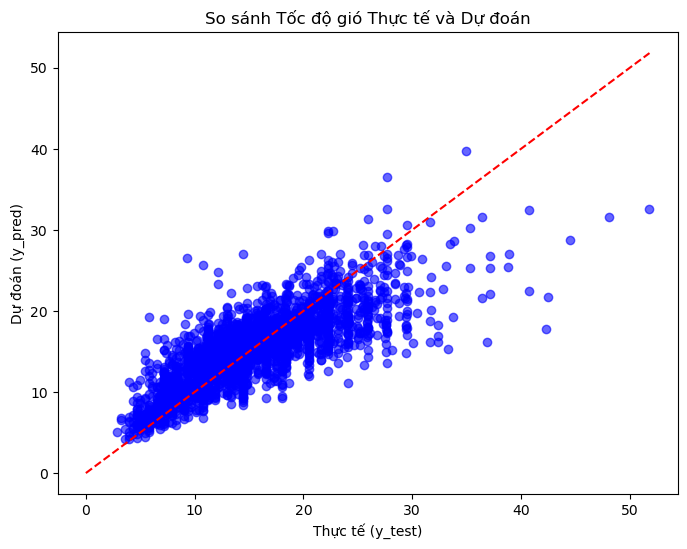

In [12]:
# 8. Vẽ biểu đồ so sánh dự đoán và thực tế
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')  # Đường chéo
plt.xlabel('Thực tế (y_test)')
plt.ylabel('Dự đoán (y_pred)')
plt.title('So sánh Tốc độ gió Thực tế và Dự đoán')
plt.show()

## Ứng dụng và điều cần lưu ý về mô hình

#### Ứng dụng:
1. **Dự báo Thời tiết**: Giúp dự đoán tốc độ gió trong tương lai, hỗ trợ các trung tâm khí tượng cảnh báo hiện tượng thời tiết cực đoan.

2. **Năng lượng Tái tạo (Điện gió)**: Dự đoán tốc độ gió để tối ưu hóa hoạt động của các trang trại điện gió, tăng hiệu quả sản xuất năng lượng.

3. **Nông nghiệp Thông minh**: Dự báo gió hỗ trợ các công việc ngoài trời như phun thuốc, tưới nước, giúp nông dân lựa chọn thời điểm làm việc hiệu quả.

4. **Giao thông và Vận tải**: Cung cấp thông tin về gió mạnh để điều chỉnh các chuyến bay và tàu, đảm bảo an toàn vận tải.

5. **Hệ thống Cảnh báo Sớm**: Tích hợp vào hệ thống cảnh báo để phát hiện và cảnh báo sớm các hiện tượng khí tượng nguy hiểm như bão, lốc xoáy.

### Lưu ý:
Mô hình này cần dự đoán các chỉ số khí tượng khác như nhiệt độ, độ ẩm, ... để có thể dự đoán tốc độ gió. Vì vậy mô hình này có thể sử dụng ở các trạm đo khí tượng, dùng các chỉ số khí tượng đo được áp dụng vào mô hình để có thể dự đoán tương lai gần tốc độ gió. Hoặc để có thể dự đoán trong tương lai xa, cần thông tin các khí tượng khác thông qua các mô hình máy học, API dự báo thời tiết,...

⟹ Có thể xây dự các mô hình dự đoán các chỉ số khí tượng khác và liên kết chúng tạo tạo thành một quy trình, lấy thông tin từ nhau để dự đoán thời tiết


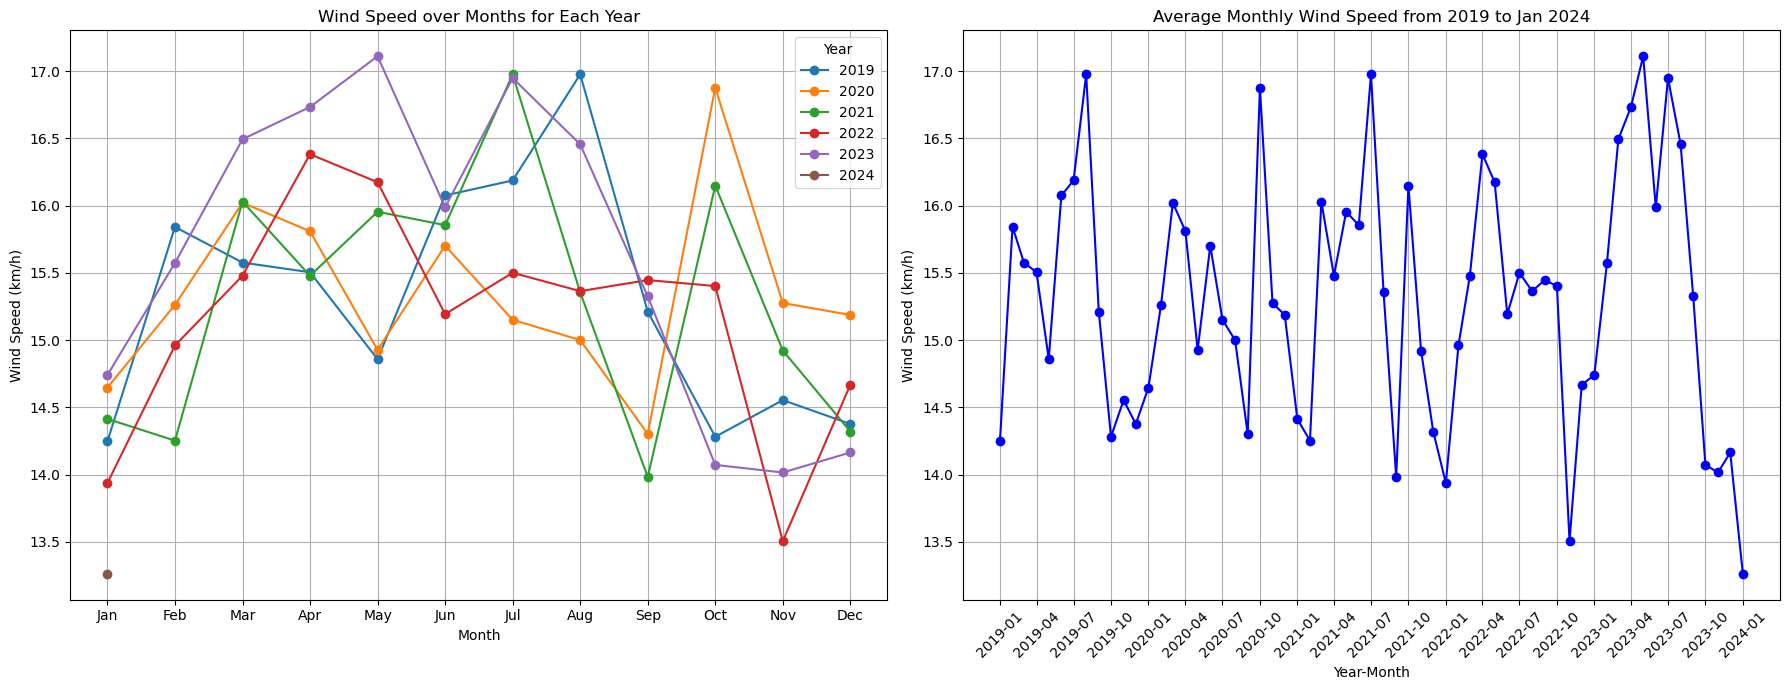

In [13]:
# Convert 'Datetime' to datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Add a 'Month' column to group by month
data['Month'] = data['Datetime'].dt.month

# Calculate the average wind speed per month for each year
monthly_windspeed = data.groupby(['Month', data['Datetime'].dt.year])['Windspeed'].mean().unstack()

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # 1 row, 2 columns

# **First chart: Wind speed over months for each year**
monthly_windspeed.plot(kind='line', marker='o', ax=axes[0])

# Customize the first plot
axes[0].set_title('Wind Speed over Months for Each Year')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Wind Speed (km/h)')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0].legend(title='Year', loc='upper right')
axes[0].grid(True)

# **Second chart: Same chart as in the first code snippet**
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Extract year and month for aggregation
data['Year'] = data['Datetime'].dt.year
data['Month'] = data['Datetime'].dt.month

# Calculate monthly average wind speed
monthly_windspeed_single = data.groupby(['Year', 'Month'])['Windspeed'].mean().reset_index()

# Create a 'Year-Month' column for the x-axis labels
monthly_windspeed_single['Year-Month'] = pd.to_datetime(monthly_windspeed_single['Year'].astype(str) + '-' + monthly_windspeed_single['Month'].astype(str).str.zfill(2))

# Plot the second chart
axes[1].plot(monthly_windspeed_single['Year-Month'], monthly_windspeed_single['Windspeed'], marker='o', linestyle='-', color='b')

# Customize the second plot
axes[1].set_title('Average Monthly Wind Speed from 2019 to Jan 2024')
axes[1].set_xlabel('Year-Month')
axes[1].set_ylabel('Wind Speed (km/h)')

# Adjust x-axis to show only every 3rd month (quarterly data)
axes[1].set_xticks(monthly_windspeed_single['Year-Month'][::3])  # Show only every 3rd month (quarterly)
axes[1].set_xticklabels(monthly_windspeed_single['Year-Month'].dt.strftime('%Y-%m')[::3], rotation=45)

axes[1].grid(True)

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Show the plots
plt.show()


## Nhận xét và phân tích biểu đồ tốc độ gió từ 01/01/2019 đến 01/01/2024:

#### 1. **Biểu đồ bên trái: Tốc độ gió trung bình theo tháng của từng năm**
   - **Xu hướng chung:** Tốc độ gió thường cao hơn vào các tháng giữa năm (khoảng từ tháng 4 đến tháng 8), đặc biệt vào mùa hè, và giảm dần vào các tháng cuối năm và đầu năm.
   - **Khác biệt theo năm:**
     - Năm 2019 và 2020 có sự tăng tốc gió khá đều và đạt đỉnh cao vào khoảng tháng 6 hoặc tháng 7.
     - Năm 2022 và 2023, tốc độ gió có biến động lớn hơn và không theo quy luật rõ ràng.
     - Năm 2024 chỉ có dữ liệu cho tháng 1, tốc độ gió ở mức thấp.

#### 2. **Biểu đồ bên phải: Tốc độ gió trung bình hàng tháng từ 2019 đến 2024**
   - **Xu hướng dài hạn:** Có sự biến động rõ rệt giữa các năm, nhưng xu hướng tổng quát cho thấy tốc độ gió đạt giá trị cao nhất vào các tháng giữa năm và thấp hơn vào các tháng cuối và đầu năm.
   - **Giai đoạn nổi bật:**
     - Giai đoạn 2019–2020: Có sự ổn định và xu hướng tăng tốc gió vào mùa hè.
     - Từ 2021 trở đi: Sự dao động bất thường hơn, có thể phản ánh tác động của các yếu tố thời tiết bất thường hoặc sự khác biệt về khu vực (do dữ liệu tổng hợp từ nhiều địa phương).

#### 3. **Kết luận quy luật chính:**
   - Tốc độ gió thường cao nhất vào mùa hè và thấp vào mùa đông.
   - Các năm gần đây (2022–2023) cho thấy sự bất ổn định trong tốc độ gió hàng tháng, có thể phản ánh tác động từ biến đổi khí hậu hoặc thay đổi điều kiện thời tiết.
   - Dữ liệu gió ở từng địa phương có thể ảnh hưởng đến xu hướng tổng thể, nên cần phân tích sâu hơn để hiểu rõ hơn về đặc thù của từng vùng.